<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>


In [4]:
import gains as genetic
import pandas as pd
import rdkit
from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import ShowMol
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
import numpy as np
from math import exp
import random
import unittest
import datetime
%matplotlib inline

GAINS can use RDKit's similarity maps to evolve candidate structures toward a random target:

0.9054054054054054
OCCCCCC([n+]1ccn(c1)C)	0.9054054054054054	starting structure	0:00:00.004528
CCCCCC[n+]1ccn(C)c1	0.9436619718309859	remove_atom	0:00:00.030587
0.9640287769784173
starting from new parent
0.881578947368421
starting from new parent
CCCCCC[n+]1ccn(CCCC)c1	0.9178082191780822	remove_atom	0:00:03.472261
0.9640287769784173
starting from new parent
0.9115646258503401
starting from new parent
C[n+]1ccn(CCCC#N)c1	0.9640287769784173	remove_atom	0:00:07.185724
0.9370629370629371
starting from new parent
C[n+]1ccn(CCCC#N)c1	0.9640287769784173	remove_atom	0:00:08.831981
0.788235294117647
starting from new parent
C[n+]1ccn(CCCC#N)c1	0.9640287769784173	remove_atom	0:00:10.497414
0.9115646258503401
starting from new parent
C[n+]1ccn(CCCC#N)c1	0.9640287769784173	remove_rdkit_fragment	0:00:12.158585
0.9370629370629371
starting from new parent
C[n+]1ccn(CCCC#N)c1	0.9640287769784173	remove_atom	0:00:13.813466
0.9253731343283582
starting from new parent
CCCCCCCn1cc[n+](C)c1	0.9370629370629

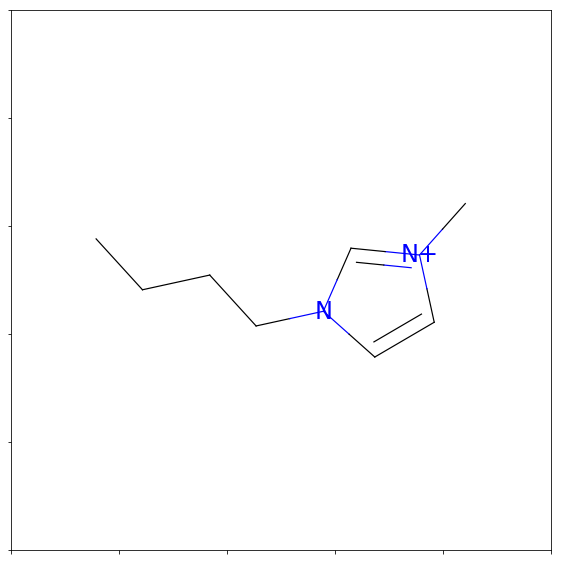

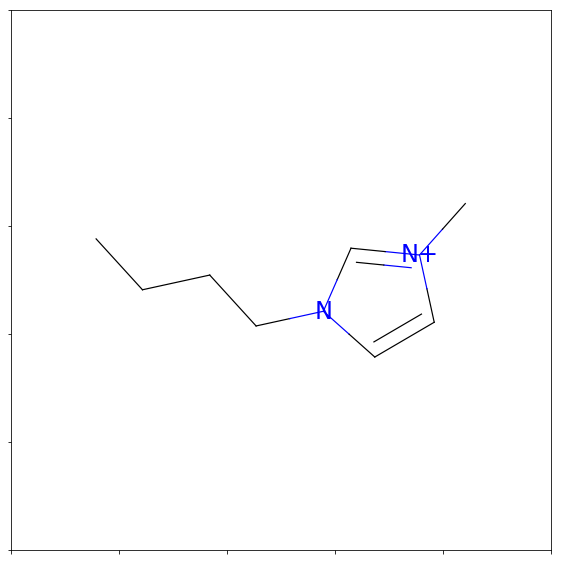

In [8]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = get_fitness(target, target)
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target)
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation, timeDiff))
    
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])

def show_ion(genes, target, mutation_attempts):
    mol = Chem.MolFromSmiles(target)
    print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    

geneSet = genetic.generate_geneset()
df = genetic.load_data("saltInfo.csv")
df = df.loc[df["cation_name"].str.contains("imid", case=False)]
df = df['cation_SMILES'].unique()
ohPickMe = random.sample(range(df.shape[0]),1)
target = df[ohPickMe[0]]
guess_password(target)
Draw.MolToMPL(Chem.MolFromSmiles(target))

Making slight changes to the above code, mainly involving the fitness function, we can use the genetic engine to search for structures of a desirable property. In this case we search for a **cation imidazole-type structure** paired with tetrafluroborate that gives a density of 800 kg/mol

0.8212894843777919
CCCCCCCCCCC[n+]1ccn(c1)C	0.8212894843777919	starting structure
CCCCC(O)CCCCCC[n+]1ccn(C)c1	0.955638012109044	add_rdkit_fragment
CCCC(O)CCCCCC[n+]1ccn(C)c1	0.972721176940531	remove_atom
CCCC(O)CCC(C)CCC[n+]1ccn(C)c1	0.9789310264483672	add_atom
CCCC(O)CCC(C)CC(C)C[n+]1ccn(C)c1	0.9976939822447748	add_atom
mutation attempts: 	53
within 1% of target density: 874 (kg/m) 


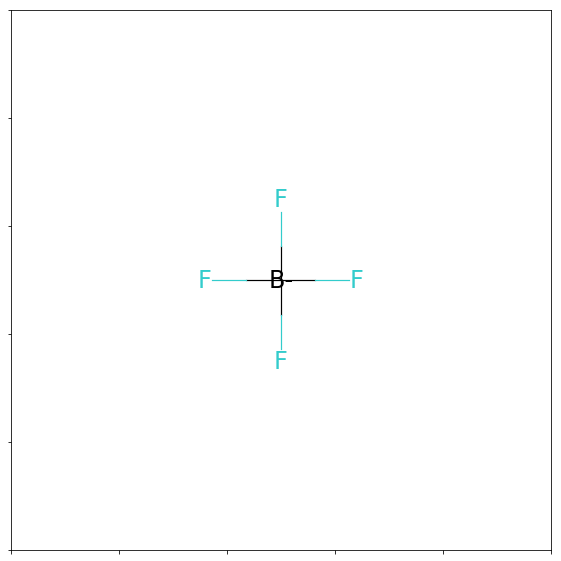

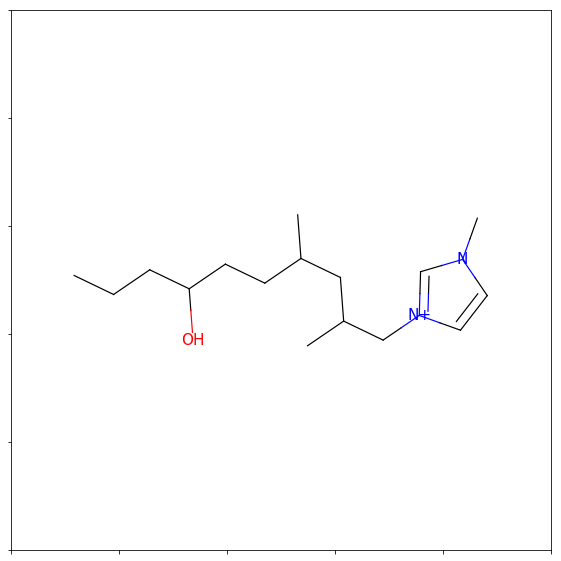

In [6]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = 0.99
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target)
    return best
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation))
    
def get_fitness(genes, target):
    cation = Chem.MolFromSmiles(genes)
    anion = Chem.MolFromSmiles("[B-](F)(F)(F)F")
    model = genetic.load_data("density_nn_model.sav", pickleFile=True)
    deslist = genetic.load_data("density_nn_model_descriptors.csv")
    feature_vector=[]
    with genetic.suppress_stdout_stderr():
        for item in deslist:
            if "anion" in item:
                feature_vector.append(calculator([item.partition('-')\
                    [0]]).CalcDescriptors(anion)[0])
            elif "cation" in item:
                feature_vector.append(calculator([item.partition('-')\
                [0]]).CalcDescriptors(cation)[0])          
            elif "Temperature_K" in item:
                feature_vector.append(298.15)
            elif "Pressure_kPa" in item:
                feature_vector.append(101.325)
            else:
                print("unknown descriptor in list: %s" % item)
    features_normalized = (feature_vector-deslist.iloc[0].values)/deslist.iloc[1].values
    prediction = exp(model.predict(np.array(features_normalized).reshape(1,-1))[0])
    error = abs((prediction-target)/target)
    
    return 1-error

def show_ion(genes, target, mutation_attempts):
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    print("within 1%% of target density: %s (kg/m) " % target)
    

geneSet = genetic.generate_geneset()
anion = Chem.MolFromSmiles("[B-](F)(F)(F)F")
target = random.sample(range(800,1500),1)[0]
best = guess_password(target)
an = Draw.MolToMPL(anion)
cat = Draw.MolToMPL(best.Mol)